In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler
import soundfile as sf
import random


In [2]:
model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=1, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

In [3]:
import torch.nn.functional as F
from torchaudio.transforms import PitchShift

In [4]:
import os
import numpy as np
import librosa
import soundfile as sf
import random

# Single function to augment the audio with time rolling and amplitude scaling
def augment_audio(file_path, n_augmentations, output_folder):
    # Load the audio file (preserve stereo if applicable)
    audio, sr = librosa.load(file_path, sr=None, mono=False)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    augmented_files = []
    
    for i in range(n_augmentations):
        # Ensure the roll amount keeps the size the same (no loss in duration)
        roll_amount = random.randint(-len(audio)//10, len(audio)//10)  # Random roll within 10% of length
        
        # Time rolling (shift the audio)
        rolled_audio = np.roll(audio, roll_amount, axis=-1)  # Preserve stereo alignment

        # Amplitude scaling (apply random scaling factor)
        scale_factor = random.uniform(0.5, 2.0)  # Random scale factor between 0.5 and 2.0
        scaled_audio = rolled_audio * scale_factor

        # Clip to prevent overflow
        scaled_audio = np.clip(scaled_audio, -1.0, 1.0)

        # # Ensure mono audio is converted to stereo
        # if scaled_audio.ndim == 1:
        #     scaled_audio = np.stack([scaled_audio, scaled_audio], axis=0)

        # Generate a unique name for the augmented file
        augmented_file_name = f'augmented_{os.path.basename(file_path).split(".")[0]}_{i+1}.wav'
        augmented_file_path = os.path.join(output_folder, augmented_file_name)
        
        # Save the augmented audio in the specified output folder
        sf.write(augmented_file_path, scaled_audio.T, sr)  # Transpose to (samples, channels)
        augmented_files.append(augmented_file_path)

    return augmented_files

# Example usage
path = '/home/AMAS_project_Joey/joeyslort/'
files = audio_files = [
    path + "GW150914_template_shifted.wav",
    path + "GW151226_template_shifted.wav",
    path + "GW170104_template_shifted.wav",
    path + "LVT151012_template_shifted.wav"
]  # List of input files

n_augmentations = 2  # Number of augmented files per input file
output_folder = '/home/AMAS_project_Joey/joeyslort/augmented_data'  # Folder to store augmented files

augmented_audio_files = []
for file in files:
    augmented_audio_files.extend(augment_audio(file, n_augmentations, output_folder))

print(f'Generated augmented files: {augmented_audio_files}')


Generated augmented files: ['/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW150914_template_shifted_1.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW150914_template_shifted_2.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW151226_template_shifted_1.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW151226_template_shifted_2.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW170104_template_shifted_1.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_GW170104_template_shifted_2.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_LVT151012_template_shifted_1.wav', '/home/AMAS_project_Joey/joeyslort/augmented_data/augmented_LVT151012_template_shifted_2.wav']


In [5]:
# change the directory to the augmented data
os.chdir('/home/AMAS_project_Joey/joeyslort/augmented_data')

# Define dataset class
class BlackHoleDataset(Dataset):
    def __init__(self, audio_files, sample_rate = 16000, audio_length = 2**18):
        self.audio_files = audio_files
        self.sample_rate = sample_rate
        self.audio_length = audio_length
        
        # Extract labels from filenames (e.g., "GW150914_template_shifted.wav" → "GW150914")
        self.labels = [os.path.basename(f).split('_')[0] for f in audio_files]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        waveform, sr = torchaudio.load(audio_path)  # Load audio

        # Resample if needed
        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)
        
        # Ensure fixed length (pad/cut)
        if waveform.shape[1] > self.audio_length:
            waveform = waveform[:, :self.audio_length]  # Trim
        else:
            pad = self.audio_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad))  # Pad
        
        text_label = self.labels[idx]  # Extract text label (e.g., "GW150914")
        return waveform, text_label

In [6]:
audio_files = [
    path + "GW150914_template_shifted.wav",
    path + "GW151226_template_shifted.wav",
    path + "GW170104_template_shifted.wav",
    path + "LVT151012_template_shifted.wav"
]
total_files = np.concatenate([audio_files, augmented_audio_files])

dataset = BlackHoleDataset(total_files) 
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True)

print(f"Total samples in dataset: {len(dataset)}")  

Total samples in dataset: 12


In [7]:
os.chdir('/home/AMAS/')

import Plot_options
C = Plot_options.standard_plot_options()
os.chdir('/home/AMAS_project_Joey/joeyslort/')

In [8]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:

# Training loop
num_epochs = 5
for epoch in range(num_epochs):  
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Wrap the dataloader with tqdm for progress tracking
    progress_bar = tqdm(dataloader, desc = f"Training Epoch {epoch+1}", leave = True)
    
    for audio_wave, text_labels in progress_bar:
        audio_wave = audio_wave.to(device)  # Move to GPU if available
        
        # Forward pass
        loss = model(
            audio_wave)
         
        loss.backward()  # Compute gradients
        
        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss = loss.item())


Epoch 1/5


Training Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/5


Training Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/5


Training Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/5


Training Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/5


Training Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

Training complete! 🎉


In [25]:
filename = "/home/AMAS_project_Joey/joeyslort/GW150914_H1_shifted.wav"
noise_sig = torchaudio.load(filename)[0].to(device)
# # make the noise signal into a duplicated stereo signal
# noise_signal = torch.cat([noise_sig, noise_sig], dim=0)
noise_signal = noise_sig / torch.max(torch.abs(noise_sig))  # Normalize
noise_signal = noise_signal.unsqueeze(0)  # Add batch dimension

generated_sample = model.sample(
    noise_signal,
    num_steps = 50
).detach().cpu().numpy()

# Save the generated audio
sf.write("/home/AMAS_project_Joey/joeyslort/generated_blackhole.wav", generated_sample[0, -1], samplerate=16000)

In [23]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate random noise instead of loading from file
noise_length = 2**14  # Fixed length
noise_signal = torch.randn((1, noise_length), device=device)  # Random mono noise

# Normalize noise
noise_signal = noise_signal / torch.max(torch.abs(noise_signal))

# Add batch dimension
noise_signal = noise_signal.unsqueeze(0)  # Shape: (1, 2, noise_length)

# Generate audio sample using the model
generated_sample = model.sample(
    noise_signal,
    num_steps=10
).detach().cpu().numpy()

# Save the generated audio as a WAV file
sf.write("/home/AMAS_project_Joey/joeyslort/generated_blackhole.wav", 
         generated_sample[0, -1], samplerate=16000)


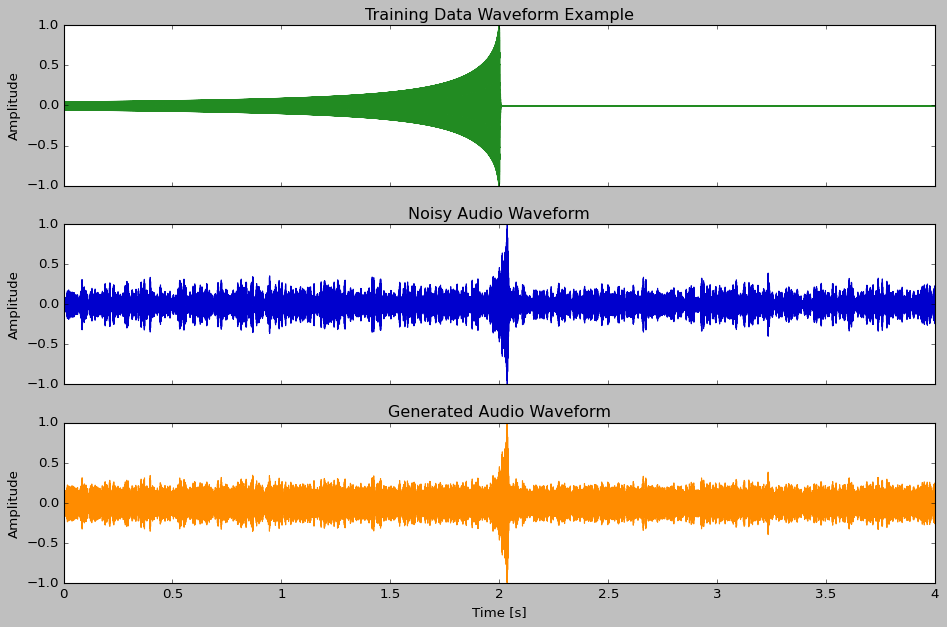

In [27]:

# Load trained-on data
file_path = "/home/AMAS_project_Joey/joeyslort/GW151226_template_shifted.wav"
trained_waveform, sr = librosa.load(file_path, sr=16000)  # Assuming 16kHz sample rate

# Extract single channel and normalize for visualization
generated_waveform = generated_sample[0, 0] / np.max(np.abs(generated_sample[0, 0]))
noise_waveform = np.array(noise_signal[0, 0])
trained_waveform = trained_waveform / np.max(np.abs(trained_waveform))

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# make the 3 plots share the x-axis
axes[0].set_xlim([0, 4])


# Plot Trained-On Audio
librosa.display.waveshow(trained_waveform, sr=sr, ax=axes[0],color=C[0])
axes[0].set_title("Training Data Waveform Example")
axes[0].set_xlabel("")
axes[0].set_ylabel("Amplitude")



# Plot Noise Signal
librosa.display.waveshow(noise_waveform, sr=4000, ax=axes[1],color=C[1])
axes[1].set_title("Noisy Audio Waveform")
axes[1].set_xlabel("")
axes[1].set_ylabel("Amplitude")

# Plot Generated Audio
librosa.display.waveshow(generated_waveform, sr=4000, ax=axes[2],color=C[2])
axes[2].set_title("Generated Audio Waveform")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Amplitude")


# Adjust layout and show
plt.tight_layout()
plt.show()
